In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
dataDirectory = '/home/h1bennet/strains/data/ATAC/'
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


### Make output directory

In [9]:
if not os.path.isdir('./peak_heatmaps/'):
    os.mkdir('./peak_heatmaps/')

# Read in differential ATAC-seq data

In [3]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_idr_peaks_merged.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (64770, 26)
getDiffExpression selected transcripts (63491, 35)
annotatePeaks selected peaks (63491, 26)


Pull intersection and union peaks

In [4]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['00_c57',
         '01_balbc',
         '02_aj']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_c57 ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 294 peaks
Intersection set at: 294 peaks

1
For comp: 00_c57 vs. 02_aj
Union set at: 389 peaks
Intersection set at: 112 peaks

2
For comp: 01_balbc vs. 02_aj
Union set at: 389 peaks
Intersection set at: 112 peaks

Analyzing 01_balbc ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 589 peaks
Intersection set at: 589 peaks

1
For comp: 00_c57 vs. 02_aj
Union set at: 589 peaks
Intersection set at: 589 peaks

1
For comp: 01_balbc vs. 02_aj
Union set at: 655 peaks
Intersection set at: 66 peaks

Analyzing 02_aj ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 655 peaks
Intersection set at: 66 peaks

0
For comp: 00_c57 vs. 02_aj
Union set at: 467 peaks
Intersection set at: 467 peaks

1
For comp: 01_balbc vs. 02_aj
Union set at: 552 peaks
Intersection set at: 68 peaks



### Extract each union set and sort by peak score

In [10]:
for key in peak_lists.keys():
    diff_peak.loc[peak_lists[key], :].sort_values('Peak Score', ascending=False).to_csv(
    './peak_heatmaps/'+key+'_peaks.txt', sep='\t')

### Annotate with ATAC-seq tags

In [23]:
with open('./annotate_peak_heatmaps.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./peak_heatmaps/*peaks.txt')):
        heatmap = peakfile.replace('_peaks.txt', '_3kb_ghist.txt')
        call = ['annotatePeaks.pl', peakfile,
                'mm10 -size 3000 -hist 50 -ghist -d \\\n',
                './merged_tagdirs/aj_Kupffer_ATAC_young_control \\\n',
                './merged_tagdirs/balbc_Kupffer_ATAC_young_control \\\n',
                './merged_tagdirs/c57_Kupffer_ATAC_young_control \\\n',
                '>', heatmap, '\n\n']
        f.write(' '.join(call))

./figures/atac_heatmap_00_c57_intersection_3kb_ghist.png
./figures/atac_heatmap_00_c57_union_3kb_ghist.png
./figures/atac_heatmap_01_balbc_intersection_3kb_ghist.png
./figures/atac_heatmap_01_balbc_union_3kb_ghist.png
./figures/atac_heatmap_02_aj_intersection_3kb_ghist.png
./figures/atac_heatmap_02_aj_union_3kb_ghist.png


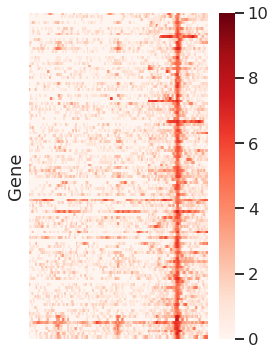

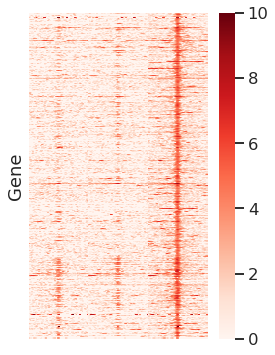

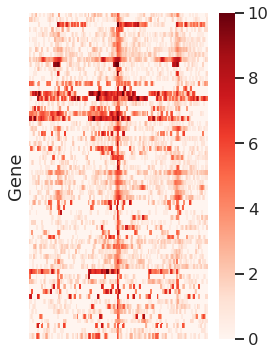

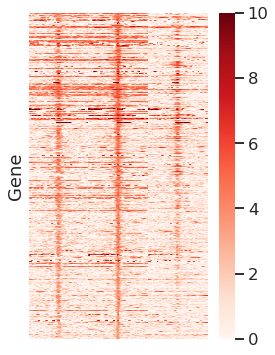

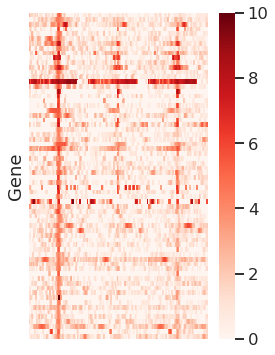

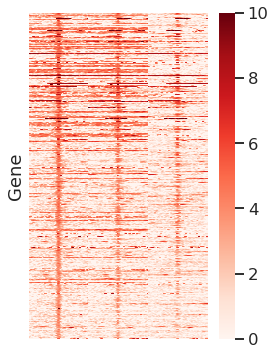

In [31]:
for i in np.sort(glob.glob('./peak_heatmaps/*ghist.txt')):
    figpath = i.replace('peak_heatmaps/', 'figures/atac_heatmap_')
    figpath = figpath.replace('.txt', '.png')
    
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    fig, ax = plt.subplots(figsize=(4,6))
    sns.heatmap(np.log2(df+1),
            cmap='Reds',
            # cbar_kws={'label':'Normalized\nTag Density'},
            vmax=10,
            xticklabels=0,
            yticklabels=0,
            ax=ax)
    
    print(figpath)
    plt.savefig(figpath)